In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Bidirectional, LSTM, Embedding, GlobalMaxPooling1D
from tensorflow.keras import Sequential

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

print(' TF Version:', tf.__version__, '\n', # 2.7.0
      'TFP Version:', tfp.__version__) # 0.15.0

 TF Version: 2.7.0 
 TFP Version: 0.15.0


## Linear Regression - Fail To Capture Aleatoric Uncertainty

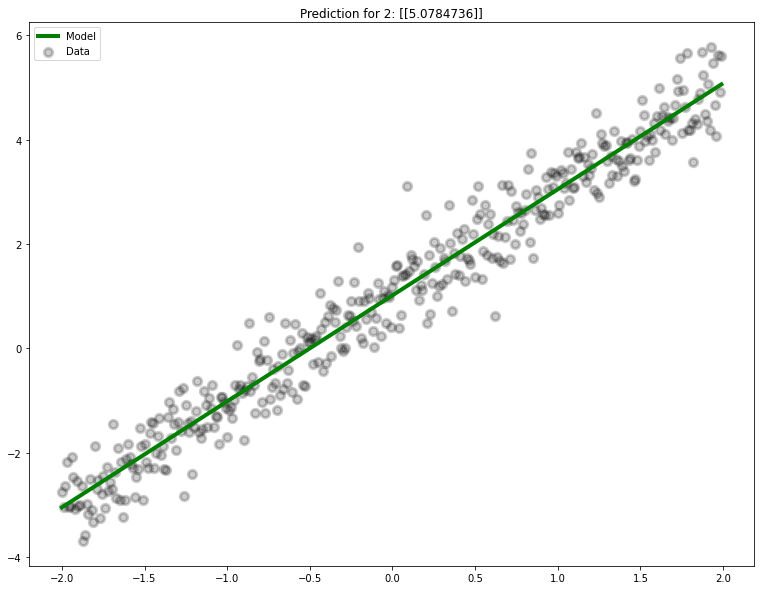

In [2]:
x = np.arange(-2, 2, 0.01)
y = 2 * x + 1 + np.random.randn(x.shape[0]) * 0.5

model = Sequential([Dense(32), Dense(1)])
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(x.reshape(-1, 1), y, epochs = 100, verbose = 0)

plt.figure(figsize = (13, 10))
plt.scatter(x, y, color = 'black', s = 70, alpha = 0.2, marker = "o", label = 'Data',
           linewidth = 3)
plt.plot(x, model.predict(x.reshape(-1, 1)), label = 'Model', color = 'green', linewidth = 4)
plt.title('Prediction for 2: {}' .format(model(tf.convert_to_tensor([2]))))
plt.legend()
plt.show()

# Introduction to TensorFlow-Probability Layers

In [3]:
def get_model(deterministic = True):
    if deterministic:
        # Output is point estimate, aka a fixed number.
        return Sequential([
                     Dense(1, activation = tf.nn.tanh,
                     kernel_initializer = 'ones',
                     bias_initializer = 'zeros')
                    ])
    else:
        # Output is a distribution object!
        return Sequential([
                Dense(1, activation = tf.nn.tanh,
                kernel_initializer = 'ones',
                bias_initializer = 'zeros'),
                tfpl.DistributionLambda(lambda x: tfd.Bernoulli(probs = x),
                           convert_to_tensor_fn = tfd.Distribution.sample)
                ])

# We model a modified version of tanh.
def predict_modelling_function(model, space):
    tanh_np = (np.exp(space) - np.exp(-space)) / (np.exp(space) + np.exp(-space))
    tanh_np = np.maximum(0, tanh_np)
    
    model_predictions = np.maximum(0, model.predict(space))
    
    print('%d model outputs are bigger than 0.5' 
          %(len(np.where(model_predictions > 0.5)[0])))
    
    plt.figure(figsize = (12, 9))
    plt.scatter(space, model_predictions, alpha=0.55, label = 'Model Output',
               color = 'green', s = 100)
    plt.plot(space, tanh_np, color='black', alpha=0.4, label = 'True Function',
            linewidth = 4)
    plt.axvline(x = 0)
    plt.axhline(y = 0)
    plt.legend()
    plt.title('Some Function vs Model Outputs')
    plt.show()

## 1) Deterministic Model

22 model outputs are bigger than 0.5


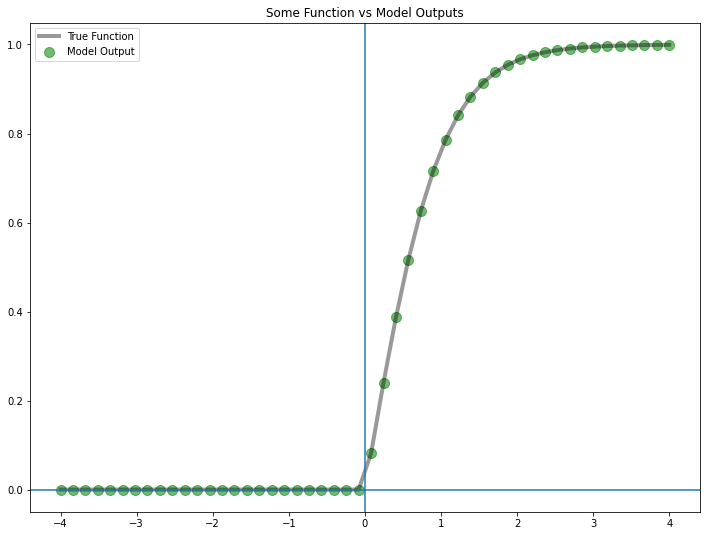

In [4]:
model = get_model(deterministic = True)

space = np.linspace(-4, 4, 50).reshape(-1, 1)
predict_modelling_function(model, space)

#### Feed Forward Object Type

In [5]:
y_hat = model(tf.convert_to_tensor([0.2]))
print('Feedforward returns:', y_hat)

tanh_np = (np.exp(0.2) - np.exp(-0.2)) / (np.exp(0.2) + np.exp(-0.2))
tanh_np = np.maximum(0, tanh_np)

if np.allclose(tanh_np, y_hat):
    print('Allclose!')

Feedforward returns: tf.Tensor([[0.19737528]], shape=(1, 1), dtype=float32)
Allclose!


#### Predict Same Sample for Five Times

In [6]:
sample = tf.convert_to_tensor([0.2])
for _ in range(5):
    print(model(sample).numpy()[0])

[0.19737528]
[0.19737528]
[0.19737528]
[0.19737528]
[0.19737528]


## 2) Model Which Outputs Distribution

In [7]:
model = get_model(deterministic = False)

y_hat = model(tf.convert_to_tensor([[0.2]]))
print('Feedforward returns:', y_hat)

Feedforward returns: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=int32)


In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (1, 1)                    2         
                                                                 
 distribution_lambda (Distri  ((1, 1),                 0         
 butionLambda)                (1, 1))                            
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
n = tf.convert_to_tensor([0.6])
for _ in range(5):
    print(model(n).sample())

tf.Tensor([[0]], shape=(1, 1), dtype=int32)
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)


22 model outputs are bigger than 0.5


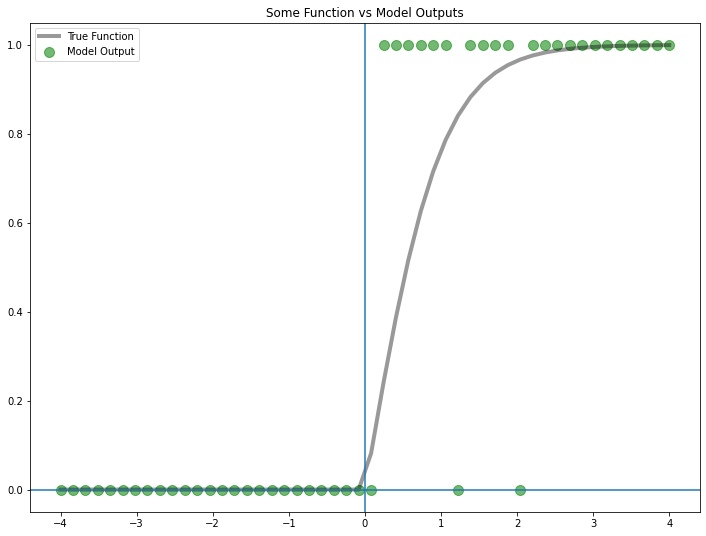

In [13]:
space = np.linspace(-4, 4, 50).reshape(-1, 1)
predict_modelling_function(model, space)

# Modeling Aleatoric Uncertainty

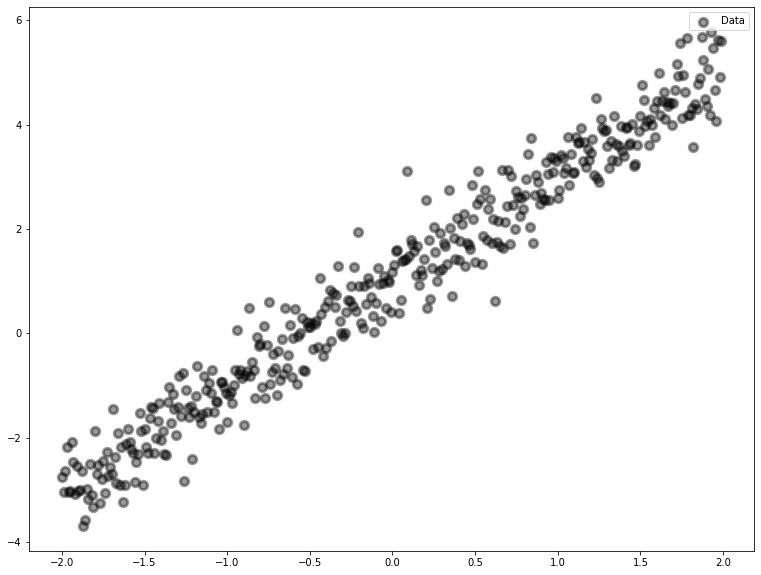

In [14]:
# Recall our data
plt.figure(figsize = (13, 10))
plt.scatter(x, y, color = 'black', s = 70, alpha = 0.4, marker = "o", label = 'Data',
           linewidth = 3)
plt.legend()
plt.show()

In [15]:
@tf.function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

### User Defined Standard Deviation

In [17]:
model = Sequential([
    Dense(32),
    Dense(1),
    tfpl.DistributionLambda(lambda x: tfd.Independent(
                                                      tfd.Normal(loc = x, 
                                                                 scale = 2)
                                                      ))
])
# Currently there were some deprecated args. If the model above does not work:
# pass reinterpreted_batch_ndims=0, so it should be: tfd.Independent(..., reinterpreted_batch_ndims=0)

model.compile(loss = nll, optimizer= 'adam')
model.fit(x.reshape(-1, 1), y, epochs= 200, verbose= 0)

print('Loss:', str(model.evaluate(x, y, verbose = False)))

Loss: 1.6406861543655396


In [18]:
model(x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[400] event_shape=[1] dtype=float32>

In [19]:
def plot_2sd_data(model, x, y):
    model_distribution = model(x)
    model_sample = model_distribution.sample()
    model_means = model_distribution.mean()
    print('Model mean:', tf.reduce_mean(model_means).numpy())
    print('Mean of the data:', y.mean())
    
    model_std = model_distribution.stddev()

    y_m2sd = model_means - 2 * model_std
    y_p2sd = model_means + 2 * model_std

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), sharey=True, dpi = 128)

    ax1.scatter(x, y, alpha=0.4, label='Data')
    ax1.scatter(x, model_sample, alpha=0.4, color='black', label='Model Samples')
    ax1.legend()
    
    ax2.scatter(x, y, alpha=0.4, label='Data')
    ax2.plot(x, model_means, color='black', alpha=0.8, label='model $\mu$')
    ax2.plot(x, y_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$', 
            linewidth = 2)
    ax2.plot(x, y_p2sd, color='green', alpha=0.8, linewidth = 2)
    ax2.legend()
    
    plt.show()

Model mean: 1.0017924
Mean of the data: 1.0012743054317013


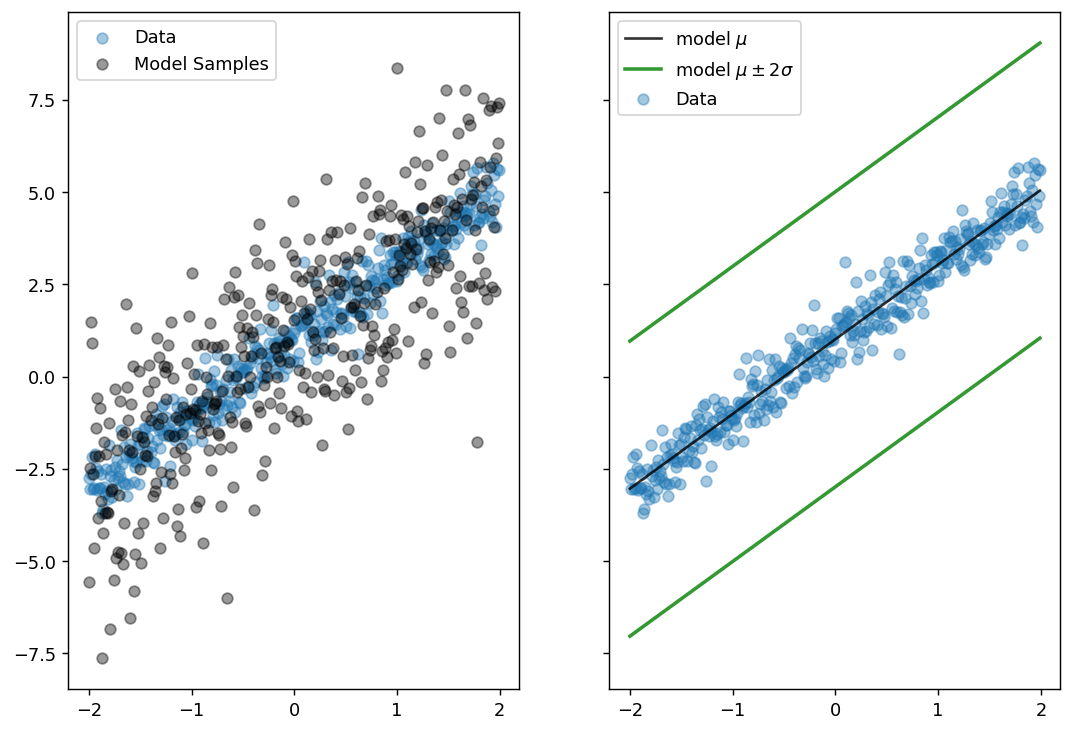

In [20]:
plot_2sd_data(model, x, y)

### Let's Also Learn The Standard Deviation

In [21]:
model = Sequential([
    Dense(32),
    Dense(1 + 1),
    tfpl.DistributionLambda(lambda x: tfd.Independent(
                                                      tfd.Normal(loc = x[..., :1], 
                                                                 scale = tf.nn.softplus(x[..., 1:]))
                                                      ))
])

model.compile(loss = nll, optimizer= 'adam')
model.fit(x.reshape(-1, 1), y, epochs= 300, verbose= 0)

print('Loss:', str(model.evaluate(x, y, verbose = False)))

Loss: 0.68198561668396


In [22]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                64        
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
 distribution_lambda_3 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


In [23]:
model(x.reshape(-1, 1))

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[400] event_shape=[1] dtype=float32>

Model mean: 0.98936194
Mean of the data: 1.0012743054317013


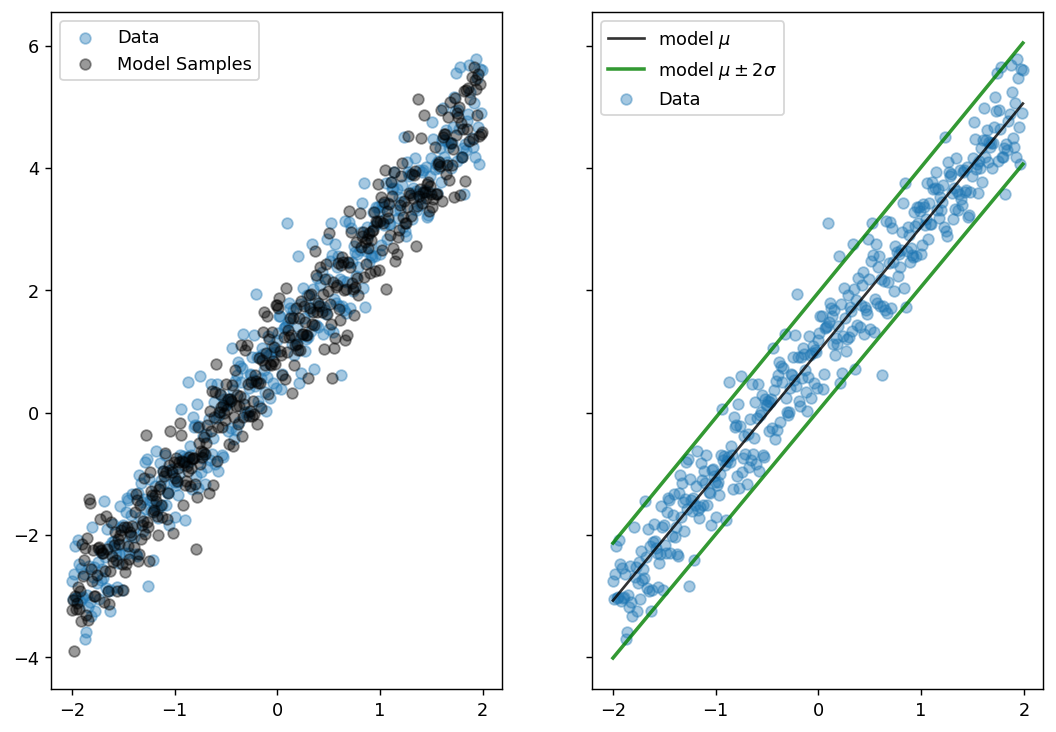

In [24]:
plot_2sd_data(model, x, y)

In [25]:
event_shape = 1
model = Sequential([
    Dense(32),
    Dense(units=tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape)
])

model.compile(loss = nll, optimizer= 'adam')
model.fit(x.reshape(-1, 1), y, epochs= 100, verbose= 0)

print('Loss:', str(model.evaluate(x, y, verbose = False)))

Loss: 0.6814663410186768


In [26]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                64        
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


Model mean: 1.0028347
Mean of the data: 1.0012743054317013


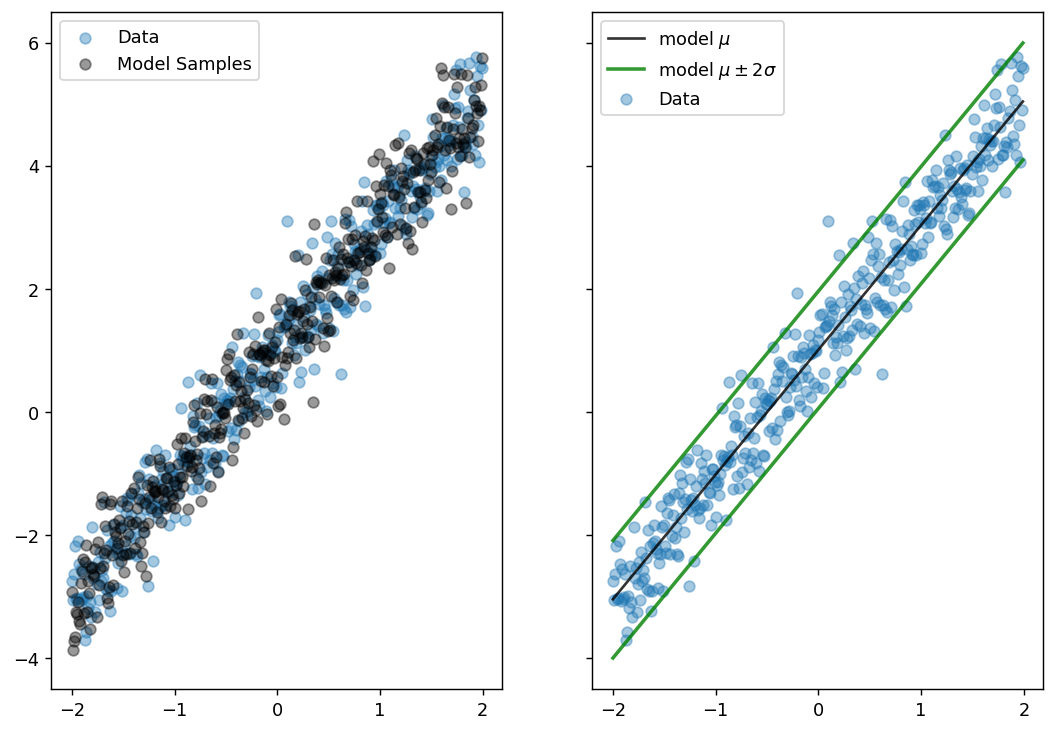

In [27]:
plot_2sd_data(model, x, y)

### Non-Linear Data

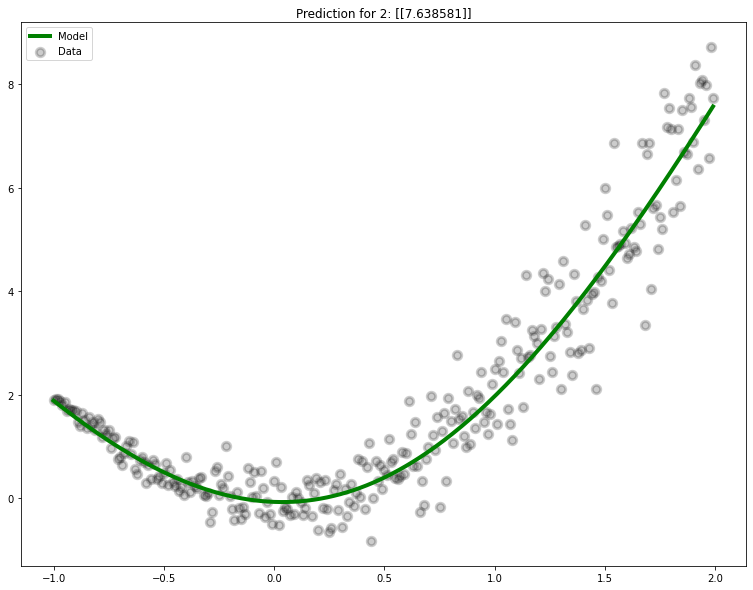

In [28]:
x = np.arange(-1, 2, 0.01)
y = 2 * np.power(x, 2) +  0.3 * (x+1.2) * np.random.randn(np.size(x))

model = Sequential([Dense(32, activation = tf.nn.silu), Dense(1)])
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(0.01))
model.fit(x.reshape(-1, 1), y, epochs = 500, verbose = False)

plt.figure(figsize = (13, 10))
plt.scatter(x, y, color = 'black', s = 70, alpha = 0.2, marker = "o", label = 'Data',
           linewidth = 3)
plt.plot(x, model.predict(x.reshape(-1, 1)), label = 'Model', color = 'green', linewidth = 4)
plt.title('Prediction for 2: {}' .format(model(tf.convert_to_tensor([2]))))
plt.legend()
plt.show()

In [29]:
event_shape = 1
model = Sequential([
    Dense(32, activation = tf.nn.silu),
    Dense(units=tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape)
])

model.compile(loss = nll, optimizer = tf.keras.optimizers.Adam(0.01))
model.fit(x.reshape(-1, 1), y, epochs = 500, verbose = False)

print('Loss:', str(model.evaluate(x, y, verbose = False)))

Loss: 0.5864775776863098


Model mean: 1.9665873
Mean of the data: 1.9722777639759261


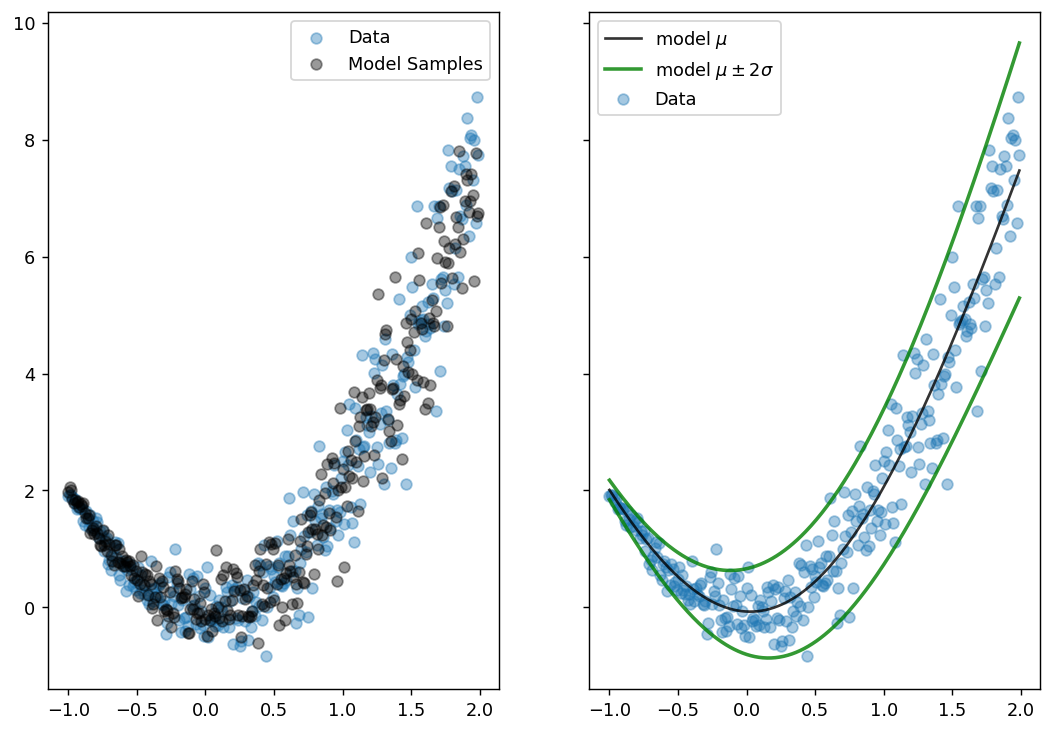

In [30]:
plot_2sd_data(model, x, y)

## Classification

In [31]:
vocab_size = 25000
max_len = 200
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128).shuffle(128).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128).prefetch(tf.data.AUTOTUNE)

In [32]:
model = Sequential([
    Embedding(vocab_size, 64, input_length = max_len),
    Conv1D(64, 7, activation = tf.nn.leaky_relu),
    Bidirectional(LSTM(32, dropout = 0.2)),
    Dense(tfpl.IndependentBernoulli.params_size(1)),
    tfpl.IndependentBernoulli(1)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           1600000   
                                                                 
 conv1d (Conv1D)             (None, 194, 64)           28736     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
 independent_bernoulli (Inde  ((None, 1),              0         
 pendentBernoulli)            (None, 1))                         
                                                                 
Total params: 1,653,633
Trainable params: 1,653,633
No

In [33]:
model.compile(loss = nll, optimizer = 'adam', metrics = ['acc'])
model.fit(train_ds, epochs = 5, validation_data = test_ds)

Epoch 1/5
196/196 [==============================] - 32s 107ms/step - loss: 0.4751 - acc: 0.6826 - val_loss: 0.3451 - val_acc: 0.7807
Epoch 2/5
196/196 [==============================] - 16s 83ms/step - loss: 0.2425 - acc: 0.8538 - val_loss: 0.3357 - val_acc: 0.8313
Epoch 3/5
196/196 [==============================] - 17s 87ms/step - loss: 0.1592 - acc: 0.9066 - val_loss: 0.3520 - val_acc: 0.8352
Epoch 4/5
196/196 [==============================] - 17s 85ms/step - loss: 0.1014 - acc: 0.9419 - val_loss: 0.3882 - val_acc: 0.8335
Epoch 5/5
196/196 [==============================] - 17s 86ms/step - loss: 0.0649 - acc: 0.9634 - val_loss: 0.4658 - val_acc: 0.8387
